# Pretrained model experiments

Follow the instructions in the README to download tapvid-davis 480 dataset with pretrained models and run inference. Helper scripts are in *benchmarking* directory.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os 
import torch
import numpy as np
import argparse
from dino_tracker import DINOTracker
from models.model_inference import ModelInference
import time

import matplotlib.pyplot as plt
from utils import add_config_paths
from data.data_utils import load_video
import cv2
import tqdm

In [2]:
plt.style.use("bmh")

## Part 1 (basic tests & visualization)

Load basic video data:

In [3]:
def get_video_with_tracks_occl(video_path, frame=0):
    config_paths = add_config_paths(video_path, {})
    occlusions_dir = config_paths["occlusions_dir"]
    video_folder = config_paths["video_folder"]
    trajs_path = os.path.join(
        config_paths["trajectories_dir"], f"trajectories_{frame}.npy"
    )
    occl_path = os.path.join(occlusions_dir, f"occlusion_preds_{frame}.npy")
    _video = load_video(
        video_folder, num_frames=300
    )  # T x 3 x H x W, torch.float32, [0, 1]
    _video = (_video.permute(0, 2, 3, 1).cpu().numpy() * 255).astype(
        np.uint8
    )  # T x H x W x 3, numpy.uint8, [0, 255]
    _tracks = np.load(trajs_path)  # [N, T, 2]
    _occluded = np.load(occl_path)
    return _video, _tracks, _occluded


video, tracks, _ = get_video_with_tracks_occl("../dataset/tapvid-davis/29")

In [4]:
video.shape

(50, 480, 854, 3)

In [5]:
tracks.shape

(23, 50, 2)

Visualizing set of query points:

(-0.5, 853.5, 479.5, -0.5)

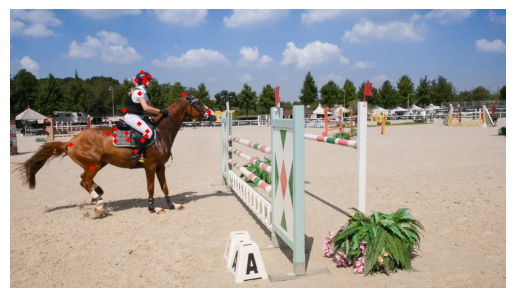

In [6]:
img0 = video[0].copy()
for pt in tracks[:, 0]:
    cv2.circle(img0, pt.astype(int), 2, (255, 0, 0), 4)

plt.imshow(img0)
plt.grid(False)
plt.axis("off")

Plot points trajectories from first to last frames:

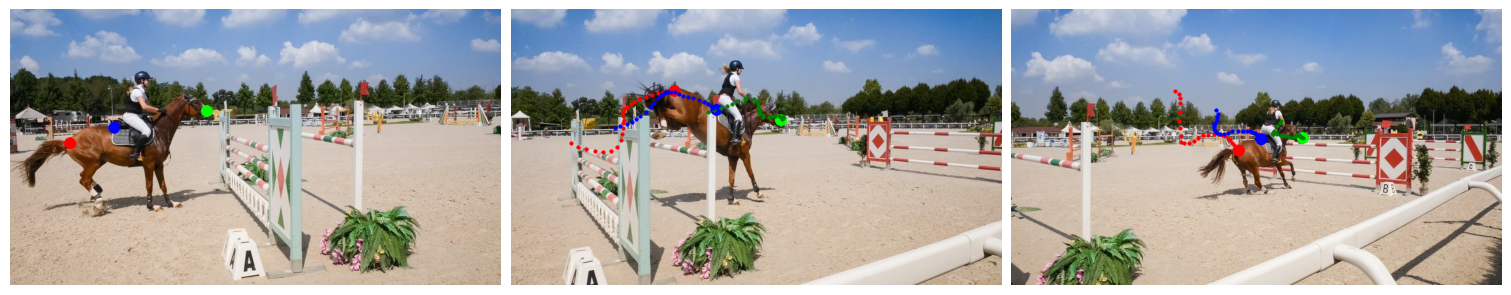

In [7]:
def plot_rude_traj(_video, _tracks, pt_indxs, name=None):
    colors_cv = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    colors_mpl = ["r", "g", "b"]

    img_first = _video[0].copy()
    img_middle = _video[_video.shape[0] // 2].copy()
    img_last = _video[-1].copy()

    fig, ax = plt.subplot_mosaic(
        [["first", "middle", "last"]], constrained_layout=True, figsize=(15, 3)
    )

    for pt_indx, clr_cv, clr_mpl in zip(pt_indxs, colors_cv, colors_mpl):
        cv2.circle(img_first, _tracks[pt_indx, 0].astype(int), 5, clr_cv, 10)
        cv2.circle(
            img_middle,
            _tracks[pt_indx, _video.shape[0] // 2].astype(int),
            5,
            clr_cv,
            10,
        )
        cv2.circle(img_last, _tracks[pt_indx, -1].astype(int), 5, clr_cv, 10)
        ax["middle"].scatter(
            _tracks[pt_indx, : _video.shape[0] // 2, 0],
            _tracks[pt_indx, : _video.shape[0] // 2, 1],
            c=clr_mpl,
            zorder=5,
            s=6,
        )
        ax["last"].scatter(
            _tracks[pt_indx, _video.shape[0] // 2 :, 0],
            _tracks[pt_indx, _video.shape[0] // 2 :, 1],
            c=clr_mpl,
            zorder=5,
            s=6,
        )

    ax["first"].imshow(img_first)
    ax["middle"].imshow(img_middle)
    ax["last"].imshow(img_last)
    ax["first"].grid(False)
    ax["middle"].grid(False)
    ax["last"].grid(False)
    ax["first"].axis("off")
    ax["middle"].axis("off")
    ax["last"].axis("off")
    if name is not None:
        fig.savefig(f"../Report/figs/{name}.png")


plot_rude_traj(video, tracks, pt_indxs=[0, 3, 5],name="davis-29")

More experiments:

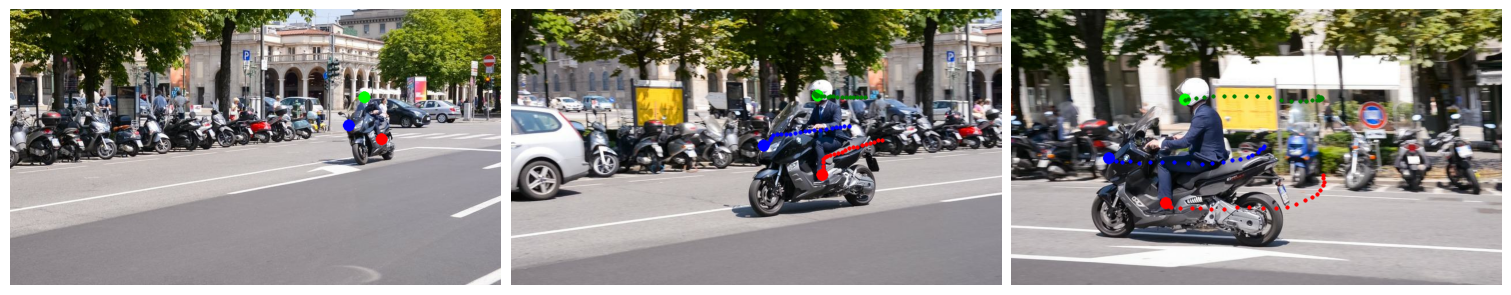

In [8]:
video_1, tracks_1, _ = get_video_with_tracks_occl("../dataset/tapvid-davis/26")
plot_rude_traj(video_1, tracks_1, pt_indxs = [0, 3, 5],name="davis-26")

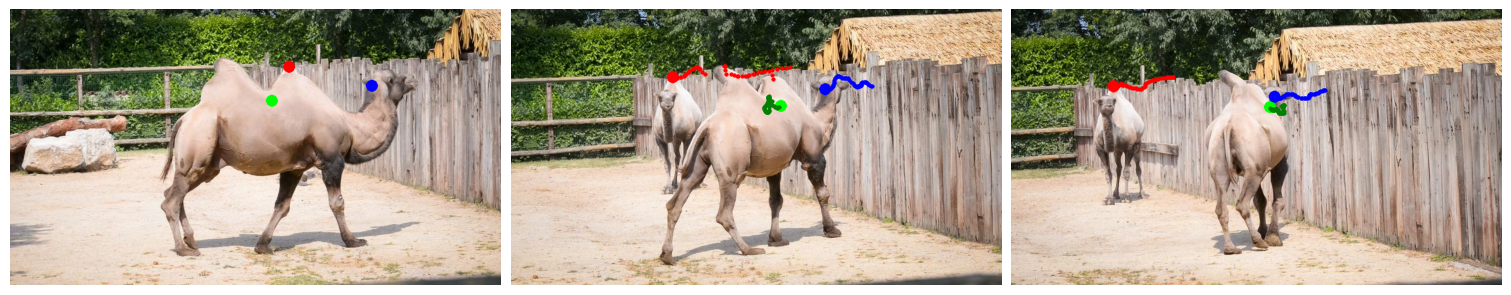

In [9]:
video_2, tracks_2, _ = get_video_with_tracks_occl("../dataset/tapvid-davis/15")
plot_rude_traj(video_2, tracks_2, pt_indxs = [0, 3, 5],name="davis-15")

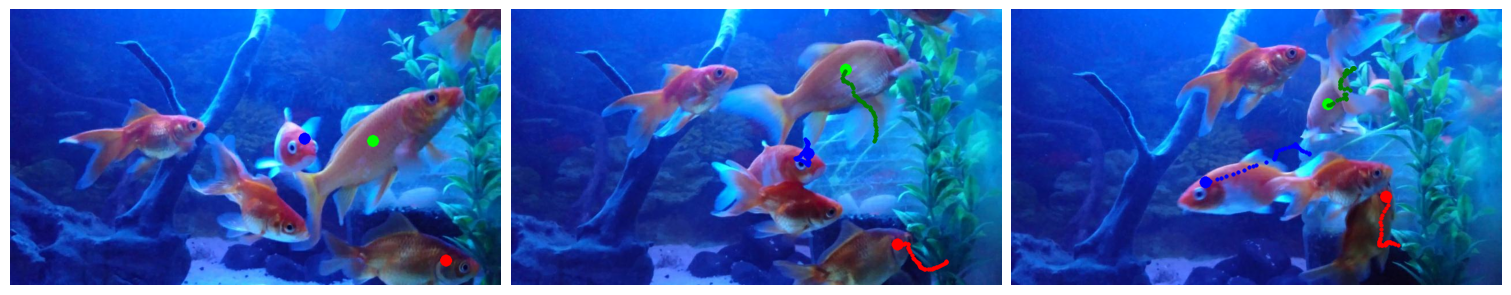

In [10]:
video_3, tracks_3, _ = get_video_with_tracks_occl("../dataset/tapvid-davis/13")
plot_rude_traj(video_3, tracks_3, pt_indxs = [2, 8, 16],name="davis-13")

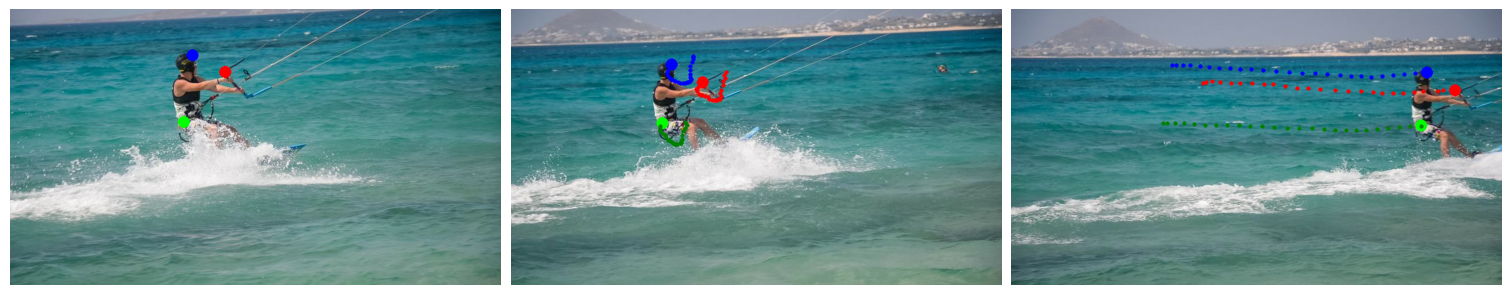

In [11]:
video_4, tracks_4, _ = get_video_with_tracks_occl("../dataset/tapvid-davis/21")
plot_rude_traj(video_4, tracks_4, pt_indxs = [0,15,8],name="davis-21")

## Part 2 (metrics)

After performing inference on every video in dataset the metrics are computed (following the instruction in README)

In [12]:
import pandas as pd

Get average metrics on dataset

In [13]:
metrics_data = pd.read_csv("../tapvid/comp_metrics_davis.csv")
metrics_data = np.round(metrics_data,5)[["video_idx", "occlusion_accuracy", "average_jaccard", "average_pts_within_thresh"]]
metrics_data.to_csv("../tapvid/comp_metrics_davis_red.csv")
metrics_data.iloc[-1,:]

video_idx                    average
occlusion_accuracy            0.8855
average_jaccard              0.65279
average_pts_within_thresh    0.80668
Name: 30, dtype: object

Promised values in README "average_pts_within_thresh: 0.8066 | occlusion_acc: 0.8854 | average_jaccard: 0.6528":

In [14]:
metrics_data.iloc[-1,:]["average_pts_within_thresh"], metrics_data.iloc[-1,:]["occlusion_accuracy"], metrics_data.iloc[-1,:]["average_jaccard"]

(0.80668, 0.8855, 0.65279)

As we can see they are on appropriate level

## Part 3 (Performance)

In [15]:
frames = []
times = []
for vid_idx in tqdm.tqdm(range(30)):
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", default="../config/train.yaml", type=str)
    parser.add_argument(
        "--data-path", default=f"../dataset/tapvid-davis/{vid_idx}", type=str
    )
    parser.add_argument(
        "--benchmark-pickle-path",
        default="../tapvid/tapvid_davis_data_strided.pkl",
        type=str,
    )
    parser.add_argument("--video-id", type=int, default=vid_idx)
    parser.add_argument(
        "--iter",
        type=int,
        default=None,
        help="Iteration number of the model to load, if None, the last checkpoint is loaded.",
    )
    parser.add_argument("--batch-size", type=int, default=1)
    args = parser.parse_args("")

    with torch.no_grad():
        dino_tracker = DINOTracker(args)
        model = dino_tracker.get_model()
        if args.iter is not None:
            model.load_weights(args.iter)
        trajectories_dir = dino_tracker.trajectories_dir
        occlusions_dir = dino_tracker.occlusions_dir
        os.makedirs(trajectories_dir, exist_ok=True)
        os.makedirs(occlusions_dir, exist_ok=True)
        model_inference = ModelInference(
            model=model,
            range_normalizer=dino_tracker.range_normalizer,
            anchor_cosine_similarity_threshold=dino_tracker.config[
                "anchor_cosine_similarity_threshold"
            ],
            cosine_similarity_threshold=dino_tracker.config[
                "cosine_similarity_threshold"
            ],
        )
        qpts_st_frame = torch.tensor(
            [[model.video.shape[-1] // 2, model.video.shape[-2] // 2, 0]],
            dtype=torch.float32,
            device="cuda:0",
        )  # N x 3, (x, y, t)
        start_time = time.time()
        trajs = model_inference.compute_trajectories(qpts_st_frame, args.batch_size)

        times.append(time.time() - start_time)
        frames.append(model.video.shape[0])

        del dino_tracker, model, model_inference

frames = np.array([frames[1:]]).T
times = np.array([times[1:]]).T

100%|██████████| 30/30 [02:10<00:00,  4.36s/it]


In [16]:
import sklearn.linear_model


lr = sklearn.linear_model.LinearRegression(fit_intercept=False)
lr.fit(frames, times)
lr.coef_

array([[0.00407428]])

Text(0, 0.5, 'Время обработки, [с]')

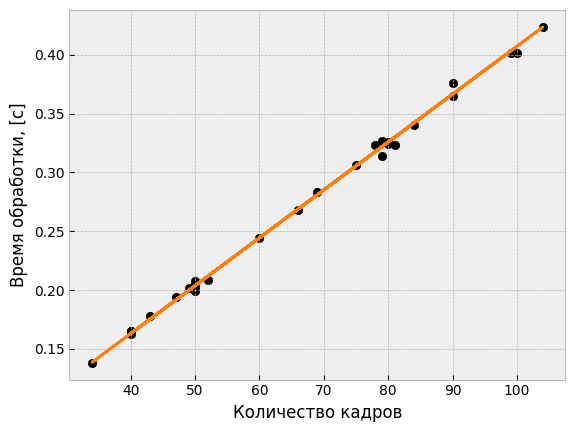

In [17]:
plt.scatter(frames, times,c="black")
plt.plot(frames, lr.predict(frames), c="tab:orange")
plt.xlabel("Количество кадров")
plt.ylabel("Время обработки, [с]")


It takes ~ 0.004s to predict trajectory points with batch size 1. Memory consumption ~ 14-15Gb.

## Part 4 (Multi-tracking)

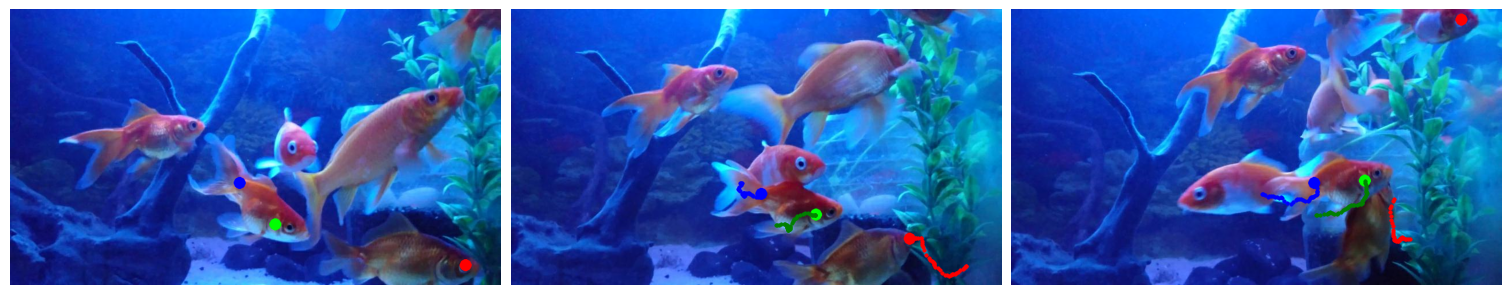

In [8]:
video_test, tracks_test, occl_test = get_video_with_tracks_occl("../dataset/tapvid-davis/13")
plot_rude_traj(video_test, tracks_test, pt_indxs = [0,10,12])

In [9]:
tracks_test.shape

(23, 78, 2)

In [10]:
occl_test.shape

(23, 78)

In [11]:
masks = cv2.imread("../dataset/tapvid-davis/13/masks/00000.png")
masks.shape

(480, 854, 3)

In [12]:
N = 50
colors = np.unique(masks.reshape((-1, 3)), axis=0)[1:]
queries = []
for col in colors:
    indices = np.where(np.all(masks == col, axis=-1))
    ids = np.random.choice(range(indices[0].shape[0]), N, False)
    queries.append(
        np.concatenate(
            [indices[1][ids].reshape((-1, 1)), indices[0][ids].reshape((-1, 1))], axis=1
        )
    )

queries = np.concatenate(queries)
queries.shape

(250, 2)

(-0.5, 853.5, 479.5, -0.5)

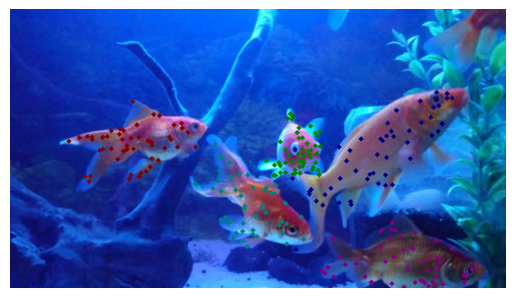

In [13]:
img0 = video_test[0].copy()
for cl_id, color in enumerate(colors):
    for pt in queries[N*cl_id:N*(cl_id+1)]:
        cv2.circle(img0, pt.astype(int), 2, tuple(map(int,color)), 4)
# for pt in queries[N:2*N]:
#     cv2.circle(img0, pt.astype(int), 2, (0, 255, 0), 4)
# for pt in queries[2*N:]:
#     cv2.circle(img0, pt.astype(int), 2, (0, 0, 255), 4)

plt.imshow(img0)
plt.grid(False)
plt.axis("off")

In [14]:
parser = argparse.ArgumentParser()
parser.add_argument("--config", default="../config/train.yaml", type=str)
parser.add_argument("--data-path", default=f"../dataset/tapvid-davis/{13}", type=str)
parser.add_argument(
    "--benchmark-pickle-path",
    default="../tapvid/tapvid_davis_data_strided.pkl",
    type=str,
)
parser.add_argument("--video-id", type=int, default=13)
parser.add_argument(
    "--iter",
    type=int,
    default=None,
    help="Iteration number of the model to load, if None, the last checkpoint is loaded.",
)
parser.add_argument("--batch-size", type=int, default=20)
args = parser.parse_args("")

with torch.no_grad():
    dino_tracker = DINOTracker(args)
    model = dino_tracker.get_model()
    if args.iter is not None:
        model.load_weights(args.iter)
    trajectories_dir = dino_tracker.trajectories_dir
    occlusions_dir = dino_tracker.occlusions_dir
    os.makedirs(trajectories_dir, exist_ok=True)
    os.makedirs(occlusions_dir, exist_ok=True)
    model_inference = ModelInference(
        model=model,
        range_normalizer=dino_tracker.range_normalizer,
        anchor_cosine_similarity_threshold=dino_tracker.config[
            "anchor_cosine_similarity_threshold"
        ],
        cosine_similarity_threshold=dino_tracker.config["cosine_similarity_threshold"],
    )
    qpts_st_frame = torch.tensor(
        np.concatenate([queries, np.zeros((queries.shape[0], 1))], 1),
        dtype=torch.float32,
        device="cuda:0",
    )  # N x 3, (x, y, t)
    start_time = time.time()
    trajs, occl = model_inference.infer(qpts_st_frame, args.batch_size)

Interating over query points: 100%|██████████| 250/250 [13:48<00:00,  3.32s/it]


In [15]:
trajs_test = trajs.cpu().detach().numpy()
occl_test = occl.cpu().detach().numpy()

In [16]:
obj_trajs = []
for i in range(len(colors)):
    obj_trajs.append(
        trajs_test[N * i : N * (i + 1)][
            (np.sum(occl_test, axis=1) == 0)[N * i : N * (i + 1)]
        ]
    )

In [28]:
video_test.shape

(78, 480, 854, 3)

(-0.5, 853.5, 479.5, -0.5)

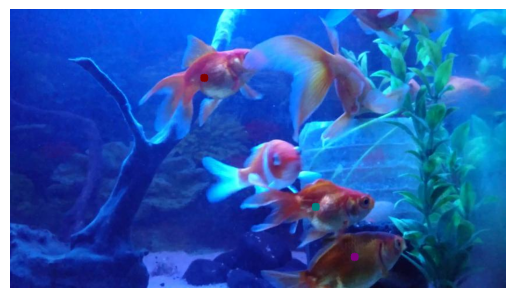

In [42]:
frame_id = np.random.randint(0, video_test.shape[0])
img0 = video_test[frame_id].copy()

for cl_id, color in enumerate(colors):
    if obj_trajs[cl_id].shape[0] == 0:
        continue
    cv2.circle(
        img0,
        np.mean(obj_trajs[cl_id], axis=0)[frame_id].astype(int),
        2,
        tuple(map(int,color)),
        10,
    )

plt.imshow(img0)
plt.grid(False)
plt.axis("off")